In [2]:
# import
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#load data and EDA

df = pd.read_csv('C:/Users/C973119/Downloads/VSC data/phi all enrollment records.csv')


In [4]:
# convert mixed format date string into datetime type
df['date'] = pd.to_datetime(df['date'], format='mixed')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3439752 entries, 0 to 3439751
Data columns (total 7 columns):
 #   Column               Dtype         
---  ------               -----         
 0   date                 datetime64[ns]
 1   event_type           object        
 2   program_name         object        
 3   preference_added_by  object        
 4   channel              object        
 5   client               object        
 6   account              float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 183.7+ MB
None


EDA

In [5]:
# counts by channel
df.groupby('channel')['account'].nunique()

channel
EMAIL     126807
PUSH      471227
SMS      1368669
VOICE      42209
Name: account, dtype: int64

In [6]:
# counts by program
df.groupby('program_name')['account'].nunique()

program_name
Outage ACE            359688
Outage DPL            535775
Outage PEP            770232
Planned Outage ACE        45
Planned Outage DPL       111
Planned Outage PEP       158
Severe Weather ACE    131729
Severe Weather DPL    161866
Severe Weather PEP    250674
Name: account, dtype: int64

In [7]:
# opco feature engineer
def last3(s):
    return s[-3:]
df['opco'] = df['program_name'].apply(last3)

# clean program name
def exceptlast4(s):
    return s[:-4]
df['program'] = df['program_name'].apply(exceptlast4)

print(df.head())

        date event_type        program_name preference_added_by channel  \
0 2020-11-10     INSERT          Outage DPL            REACHAPI     SMS   
1 2020-11-10     INSERT  Severe Weather DPL            REACHAPI     SMS   
2 2020-11-10     DELETE          Outage DPL            REACHAPI     SMS   
3 2020-11-10     INSERT          Outage ACE            REACHAPI   EMAIL   
4 2020-11-10     INSERT          Outage PEP            REACHAPI   EMAIL   

  client       account opco         program  
0    PHI  5.002460e+10  DPL          Outage  
1    PHI  5.002505e+10  DPL  Severe Weather  
2    PHI  5.501131e+10  DPL          Outage  
3    PHI  5.500147e+10  ACE          Outage  
4    PHI  5.002349e+10  PEP          Outage  


In [8]:
# counts by opco
df.groupby(['opco', 'channel'])['account'].nunique()

opco  channel
ACE   EMAIL       34747
      PUSH       111361
      SMS        286356
      VOICE       10735
DPL   EMAIL       31958
      PUSH       141701
      SMS        460793
      VOICE       12588
PEP   EMAIL       60117
      PUSH       218182
      SMS        621548
      VOICE       18903
Name: account, dtype: int64

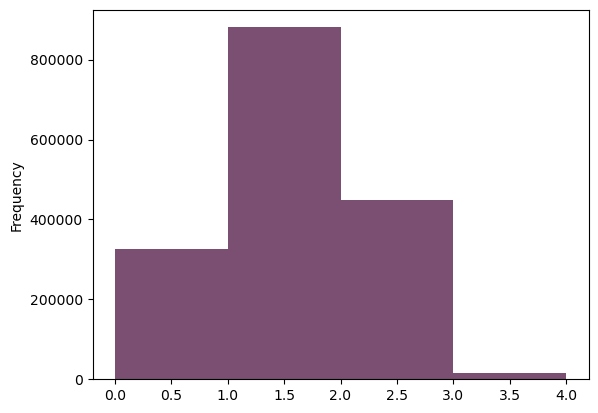

In [9]:
# counts of channel per customer
ccounts = df.groupby(['account', 'event_type'])['program'].nunique()
ccounts = ccounts.unstack(level=-1)
ccounts = ccounts.fillna(0)
ccounts['net'] = ccounts['Initial'] + ccounts['INSERT'] - ccounts['DELETE']

ccounts['net'].plot(kind='hist', color = '#7B4F71', bins=[0,1,2,3,4])
plt.show()


In [11]:
# counts by program
df.groupby(['opco','program'])['account'].nunique()

opco  program       
ACE   Outage            359688
      Planned Outage        45
      Severe Weather    131729
DPL   Outage            535775
      Planned Outage       111
      Severe Weather    161866
PEP   Outage            770232
      Planned Outage       158
      Severe Weather    250674
Name: account, dtype: int64

In [12]:
# engineer month and year features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
print(df.head())

        date event_type        program_name preference_added_by channel  \
0 2020-11-10     INSERT          Outage DPL            REACHAPI     SMS   
1 2020-11-10     INSERT  Severe Weather DPL            REACHAPI     SMS   
2 2020-11-10     DELETE          Outage DPL            REACHAPI     SMS   
3 2020-11-10     INSERT          Outage ACE            REACHAPI   EMAIL   
4 2020-11-10     INSERT          Outage PEP            REACHAPI   EMAIL   

  client       account opco         program  year  month  
0    PHI  5.002460e+10  DPL          Outage  2020     11  
1    PHI  5.002505e+10  DPL  Severe Weather  2020     11  
2    PHI  5.501131e+10  DPL          Outage  2020     11  
3    PHI  5.500147e+10  ACE          Outage  2020     11  
4    PHI  5.002349e+10  PEP          Outage  2020     11  


All opco Aggregation Analysis

In [13]:
# slice df to channel
sms = df[df.channel == 'SMS']
push = df[df.channel == 'PUSH']
email = df[df.channel == 'EMAIL']
voice = df[df.channel == 'VOICE']

In [14]:
# define function to perform unsubscription rate calculation
def unrate(df):
    ym = df.groupby(['year', 'month', 'event_type'])['account'].nunique()
    ym = ym.unstack(level=-1) #last level of index, here it's event_type

    # calculate cummulative
    ym['cumdel'] = ym['DELETE'].cumsum()
    ym['cumins'] = ym['INSERT'].cumsum()

    # lag a row to get beginning balance
    beg = ym.iloc[0,2]
    ym['endins'] = ym['cumins'] - ym['cumdel'] + beg
    ym['begins'] = ym['endins'].shift(1)

    ym['unrate'] = ym['DELETE'] / ym['begins'] * 100
    return ym

In [15]:
# calcualate unsubscription rate
ym_sms = unrate(sms)
ym_push = unrate(push)
ym_email = unrate(email)
ym_voice = unrate(voice)

In [16]:
# define a plot function
def complot(df):
    fig, ax1 = plt.subplots(figsize=(15,8))
    df.loc[2023]['endins'].plot(kind='bar', ax=ax1, color='#3599B8')
    plt.ylabel('enrollment base')

    ax2=ax1.twinx()
    df.loc[2023]['unrate'].plot(kind='line', ax=ax2, color='#7B4F71')
    plt.ylabel('unsubscription rate %')
    
    return fig

Visuals of monthly unsubscription and subscription base

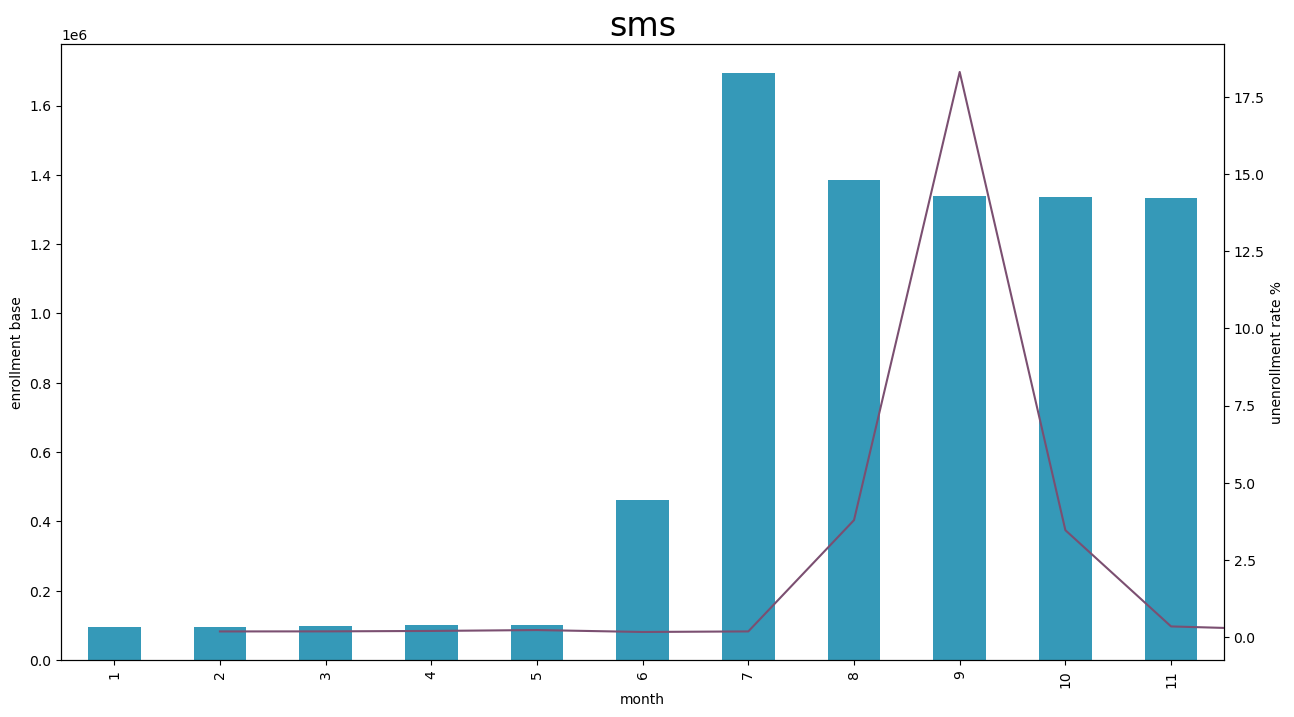

In [17]:
# use the plot function to generate visual
complot(ym_sms)
plt.title('sms', fontsize=24)
plt.show()

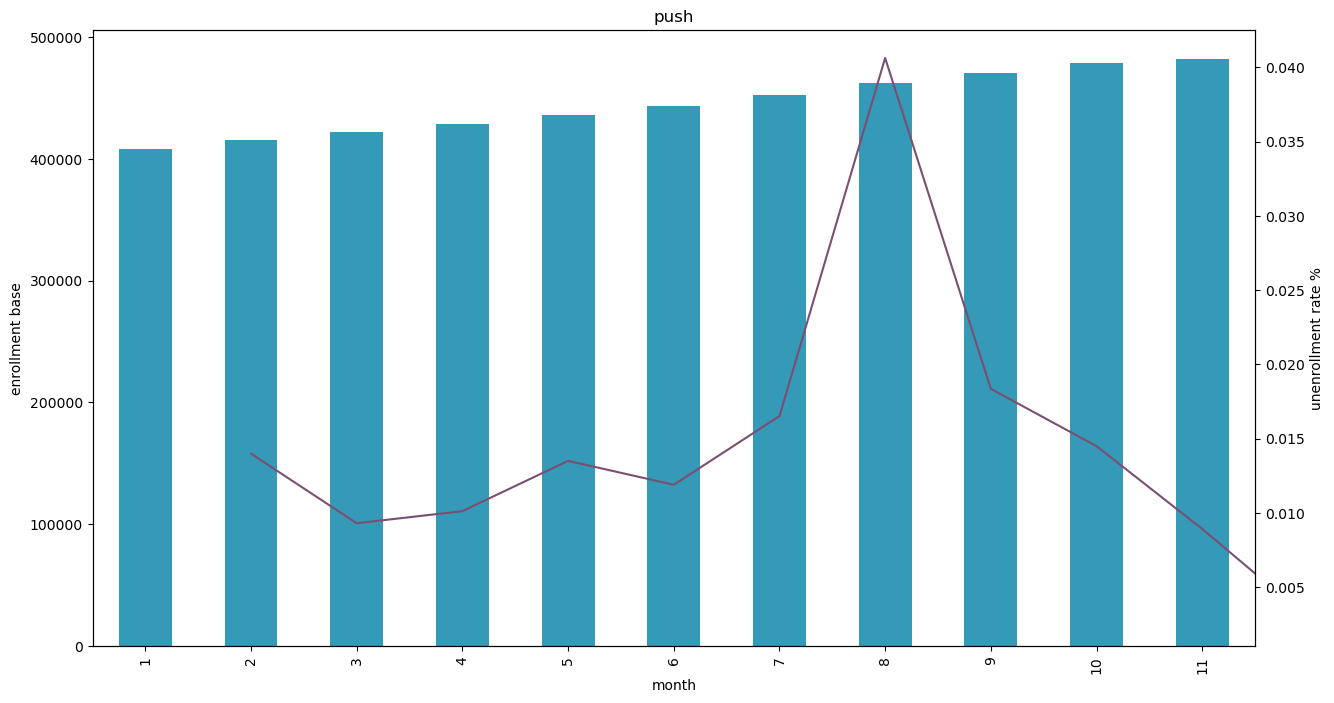

In [18]:
# Push channel
complot(ym_push)
plt.title('push')
plt.show()

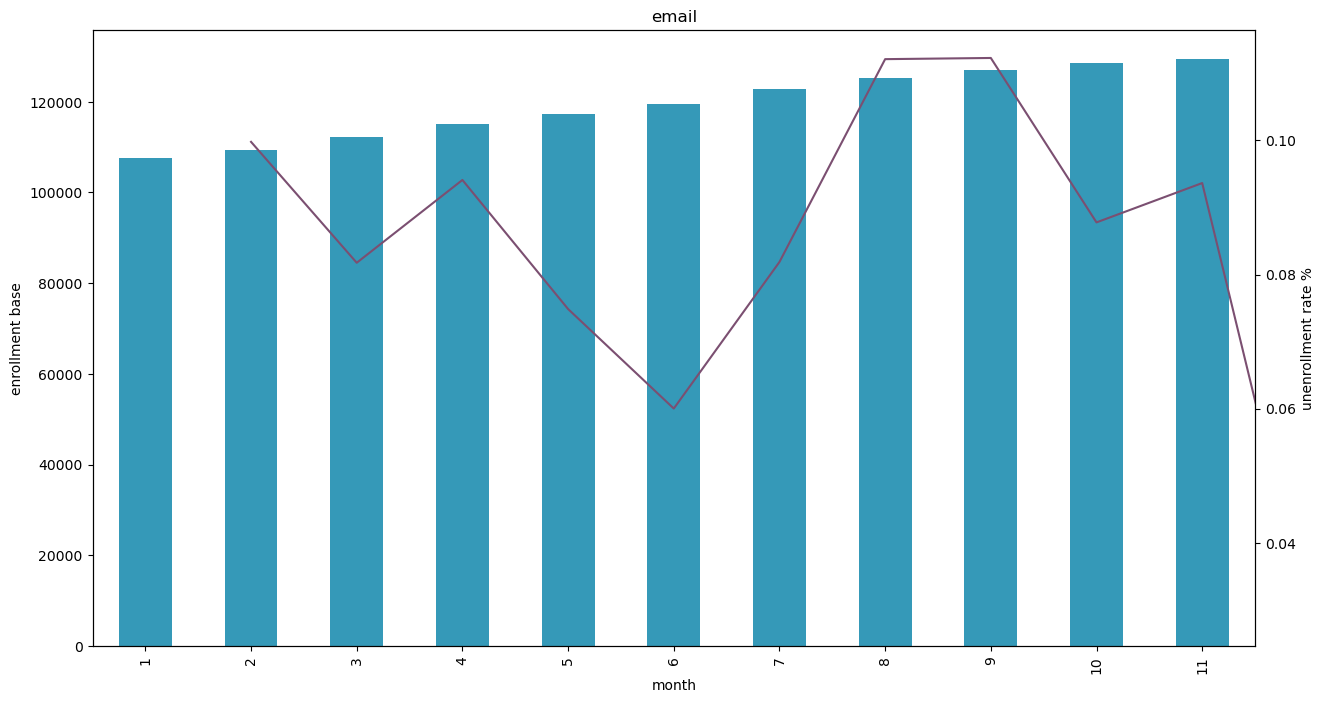

In [19]:
# Email channel
complot(ym_email)
plt.title('email')
plt.show()

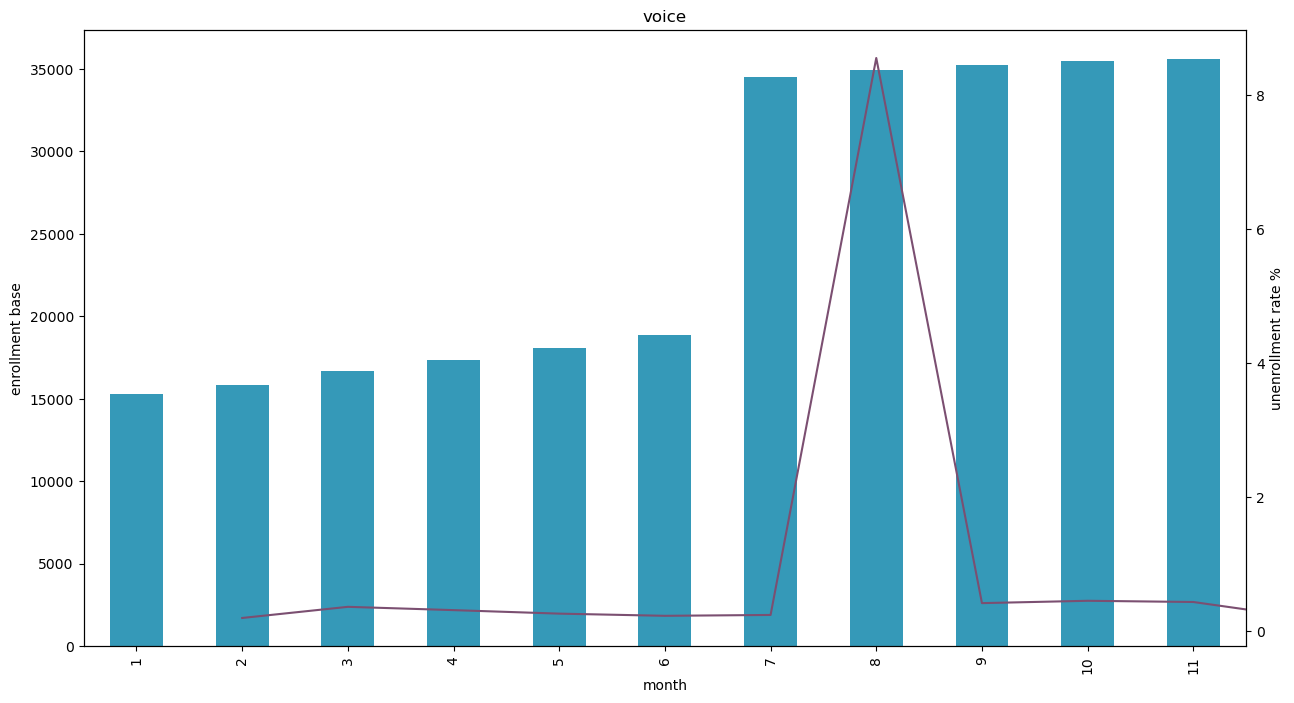

In [20]:
# Voice channel
complot(ym_voice)
plt.title('voice')
plt.show()

Program unsubscription analysis

In [21]:
# slice data by program
op = df[df['program']=='Outage']
pop = df[df['program'] == 'Planned Outage']
swp = df[df['program']=='Severe Weather']

In [22]:
# calculate unsubscription rate
ym_op = unrate(op)
ym_pop = unrate(pop)
ym_swp = unrate(swp)

Operating company breakdown analysis

opco DPL
Processing SMS ...


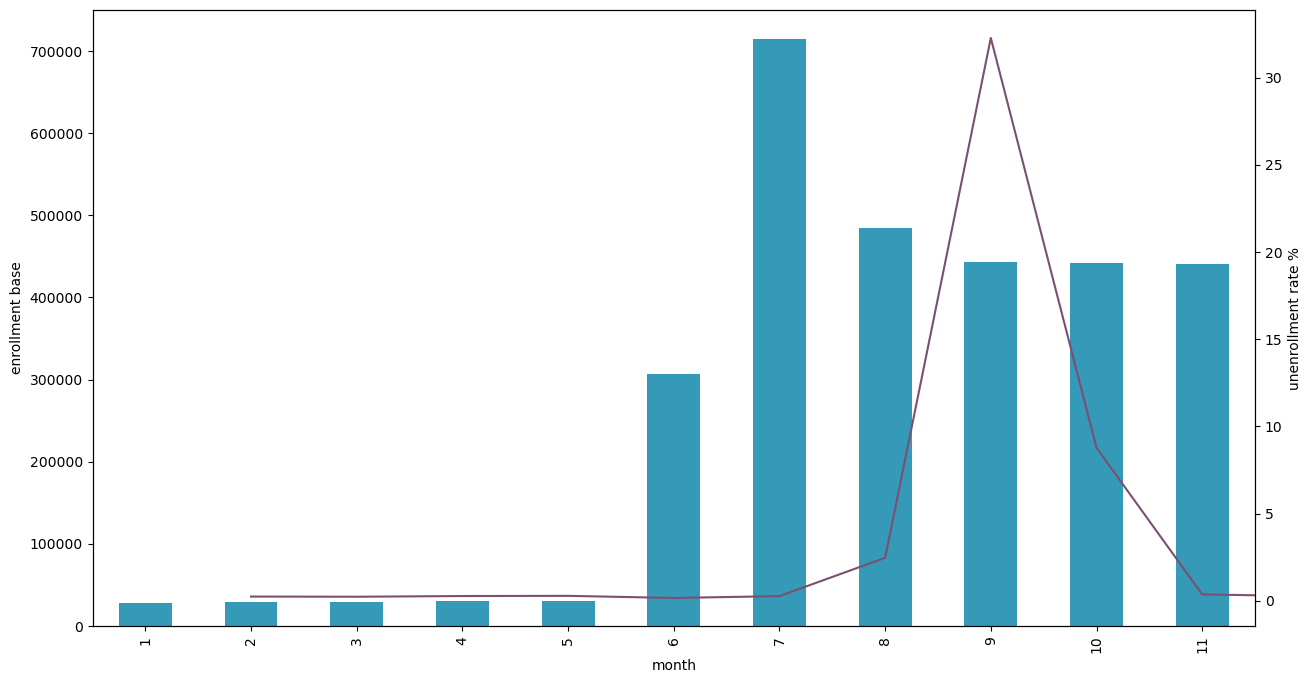

Processing EMAIL ...


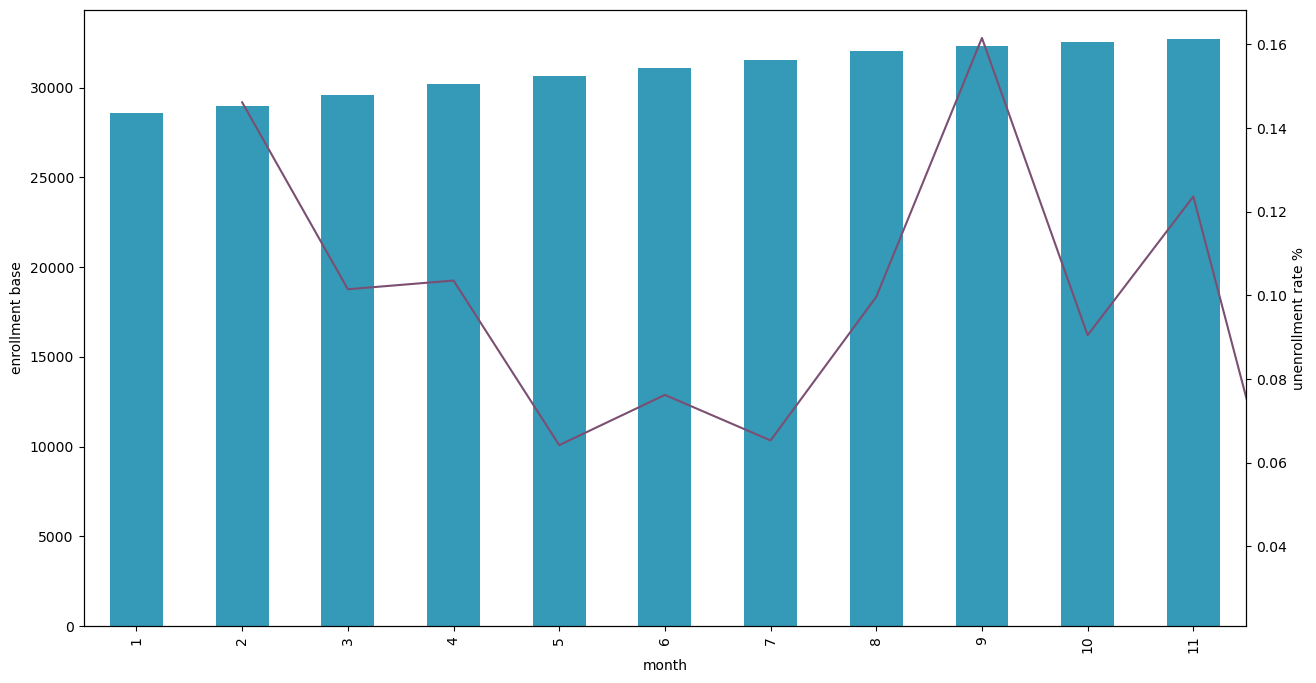

Processing VOICE ...


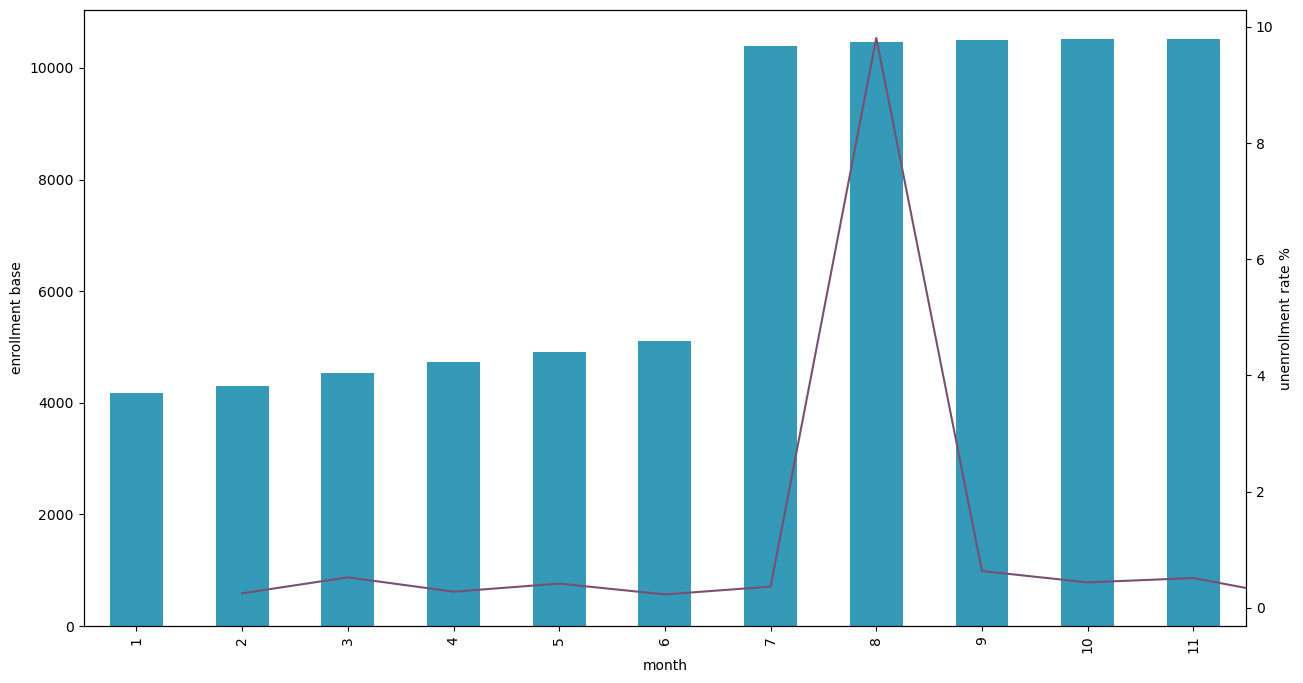

Processing PUSH ...


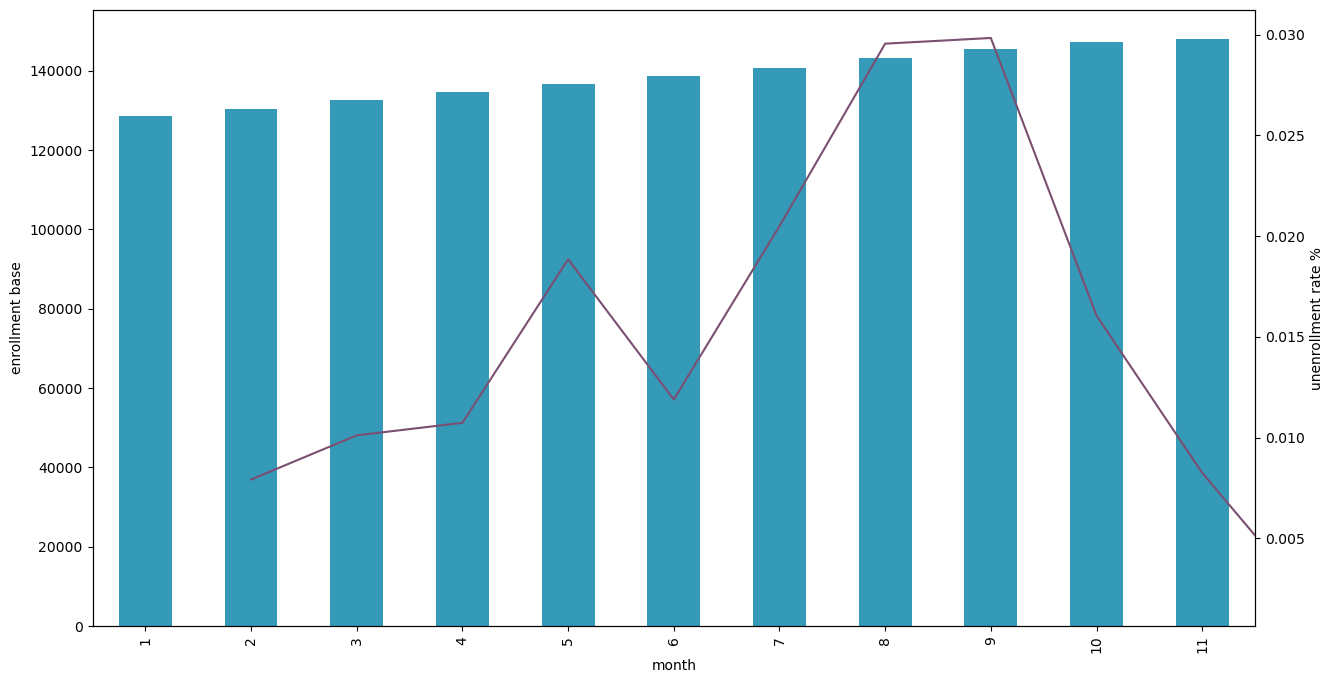

opco ACE
Processing SMS ...


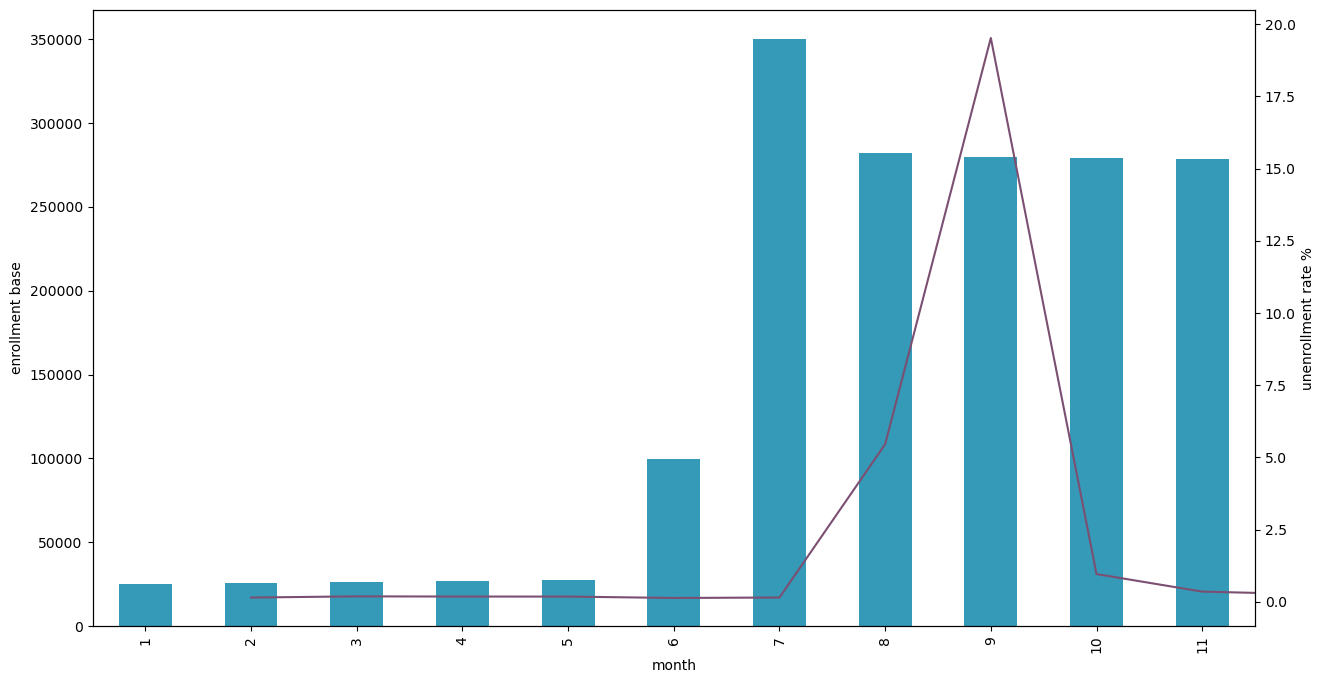

Processing EMAIL ...


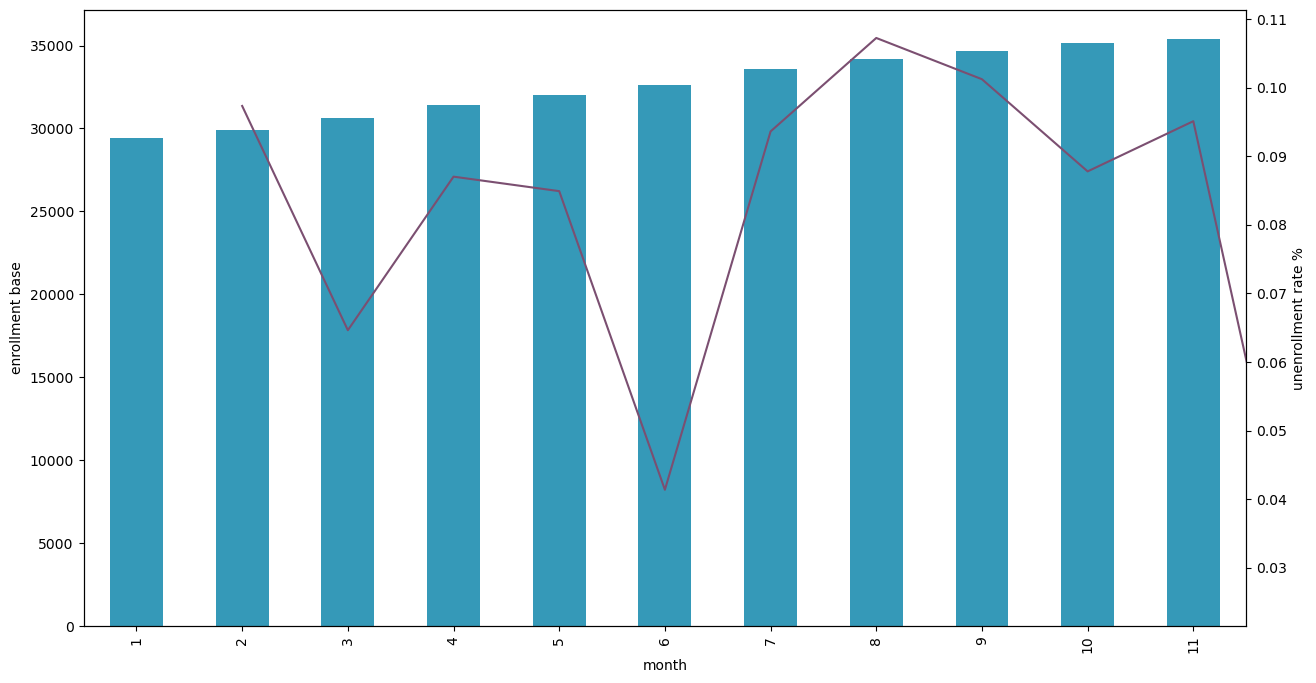

Processing VOICE ...


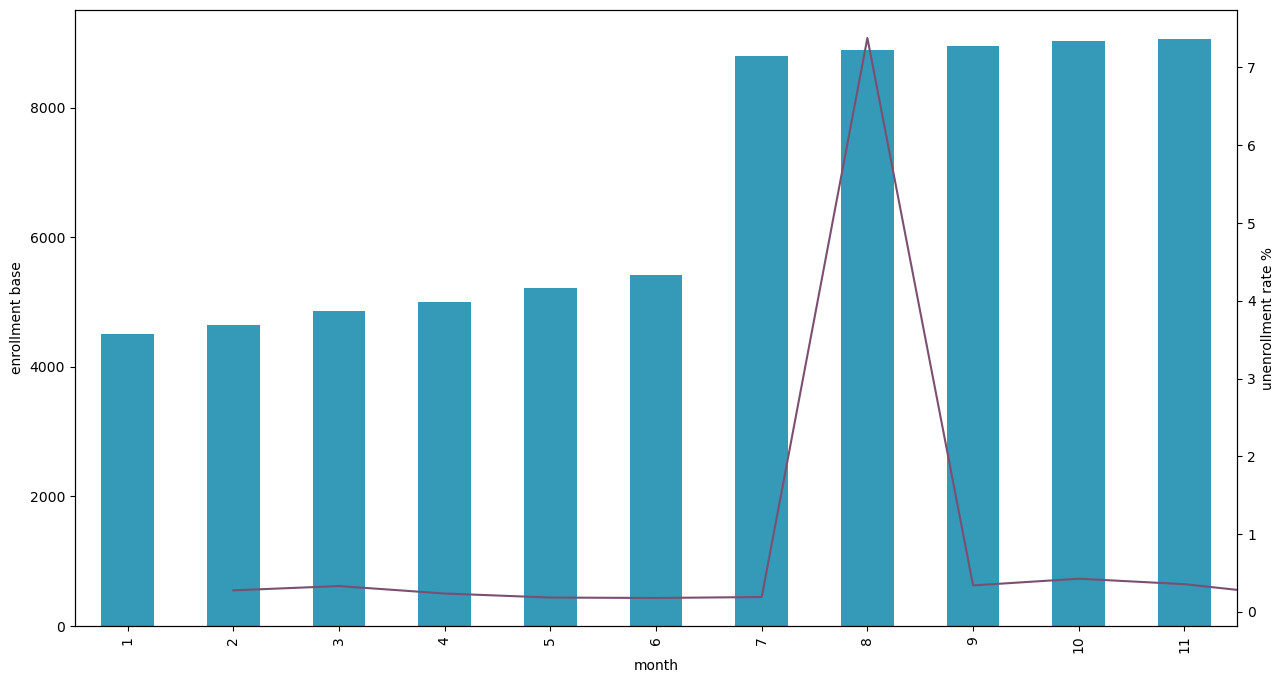

Processing PUSH ...


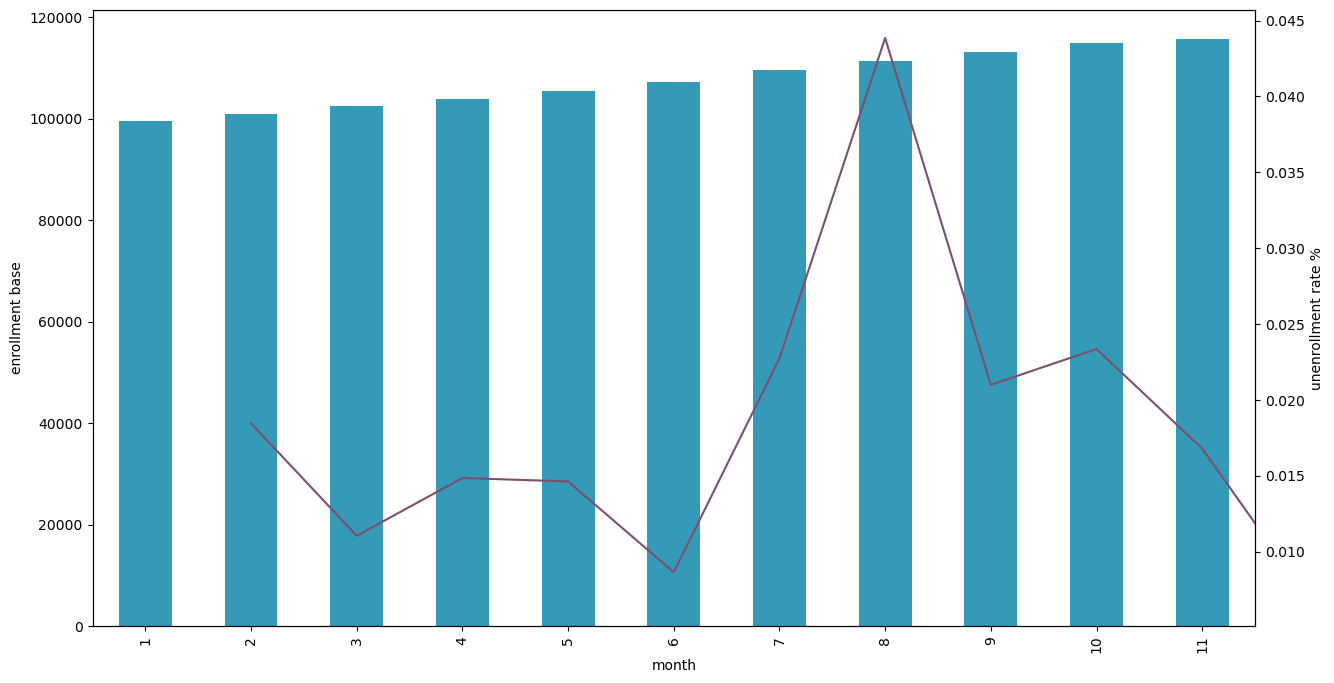

opco PEP
Processing SMS ...


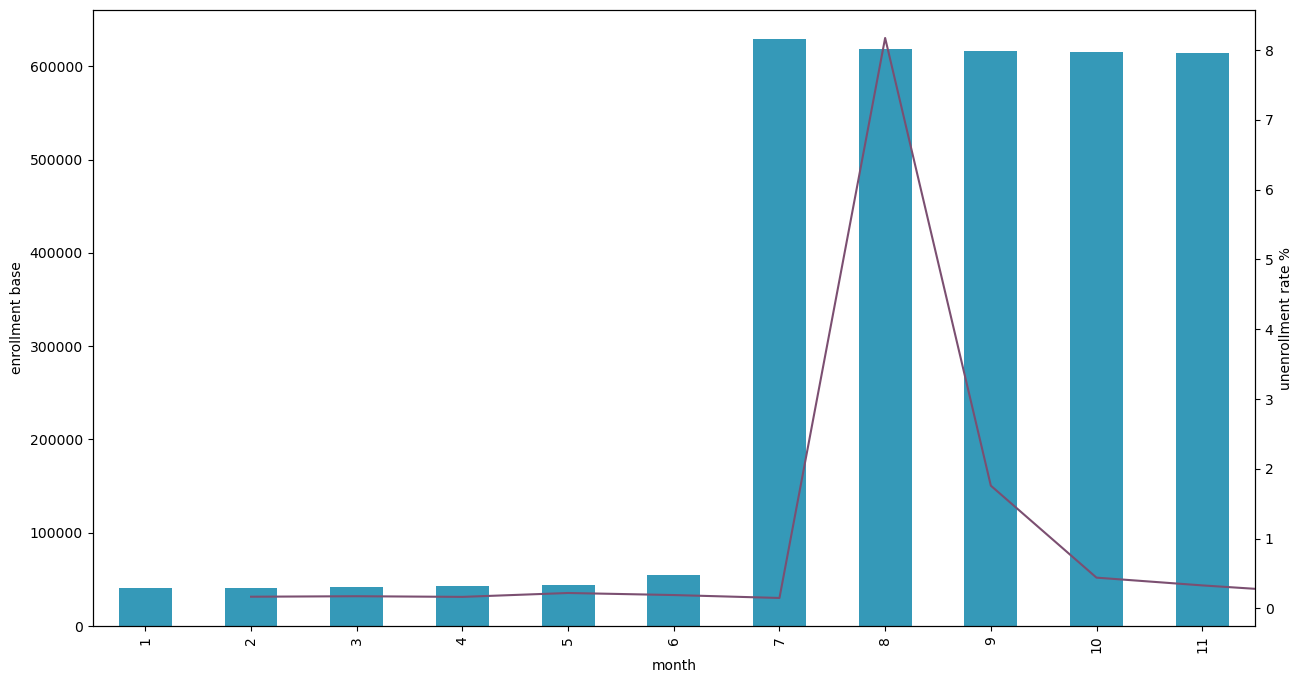

Processing EMAIL ...


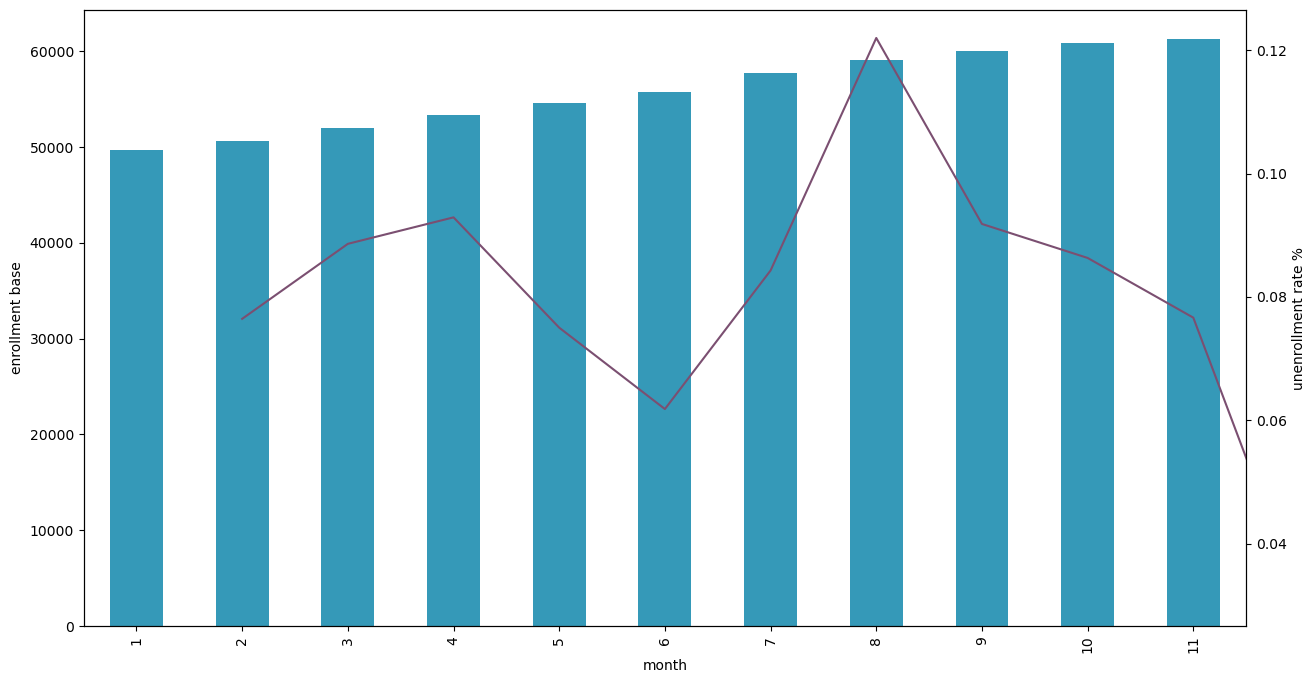

Processing VOICE ...


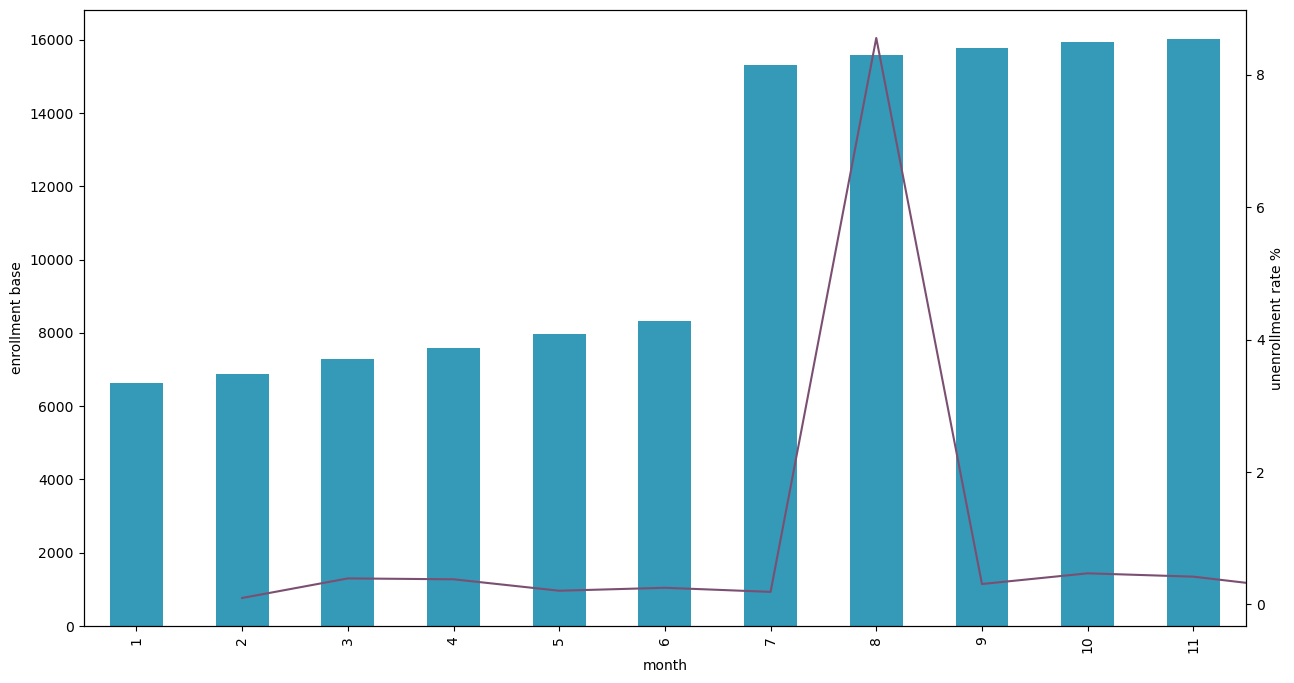

Processing PUSH ...


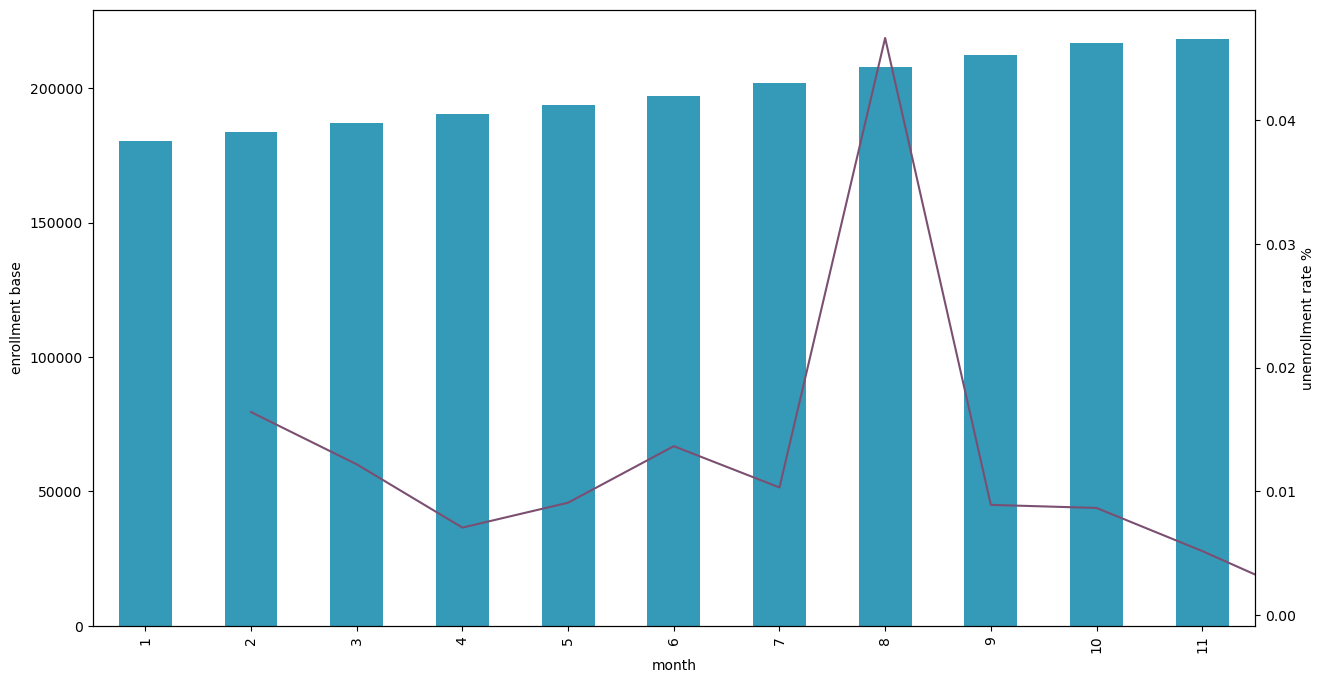

In [23]:
# for loop to run analysis for all opco at once
opco = df.opco.unique()
channel = df.channel.unique()

for opco in opco:
    print('opco {}'.format(opco))
    opco = df[df['opco'] == opco]
    for chan in channel:
        print('Processing {} ...'.format(chan))
        chan = opco[opco['channel'] == chan]
        counts = unrate(chan)
        
        complot(counts)
        plt.show()


In [24]:
# prepare data
asms = ace[ace.channel == 'SMS']
apush = ace[ace.channel == 'PUSH']
aemail = ace[ace.channel == 'EMAIL']
avoice = ace[ace.channel == 'VOICE']

ace_sms = unrate(asms)
ace_push = unrate(apush)
ace_email = unrate(aemail)
ace_voice = unrate(avoice)

NameError: name 'ace' is not defined

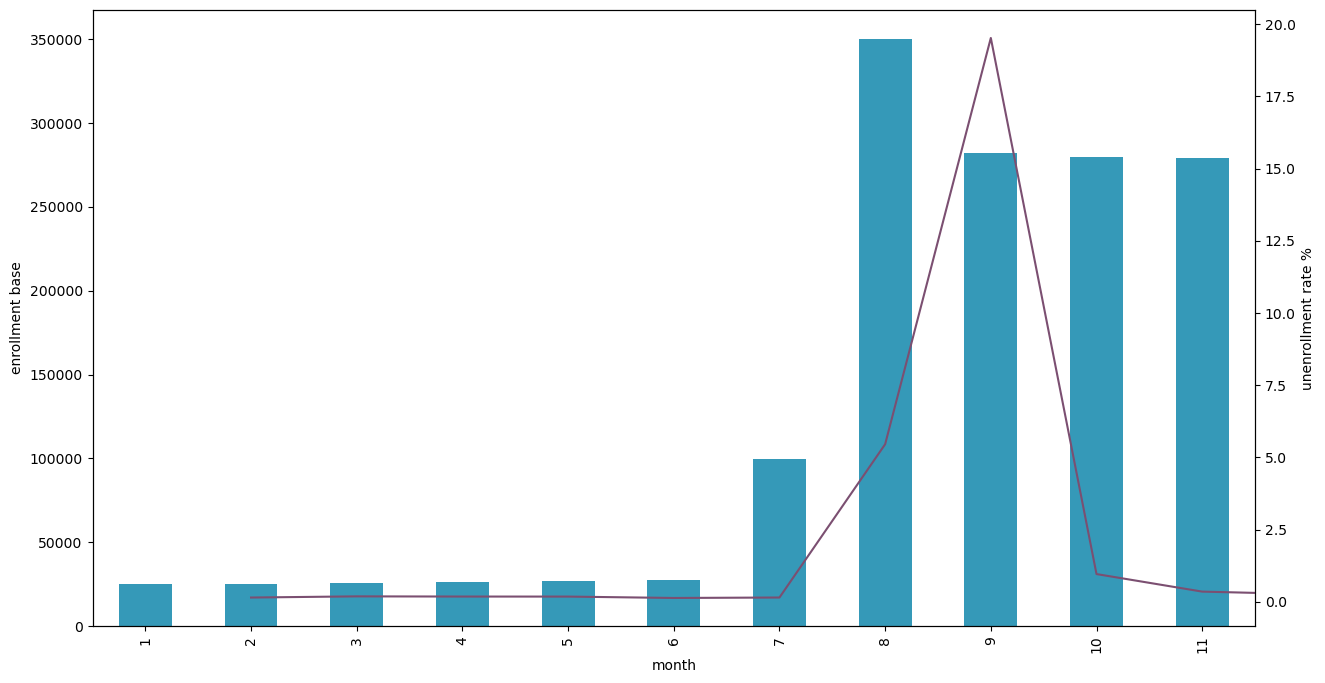

In [ ]:
complot(ace_sms)
plt.show()

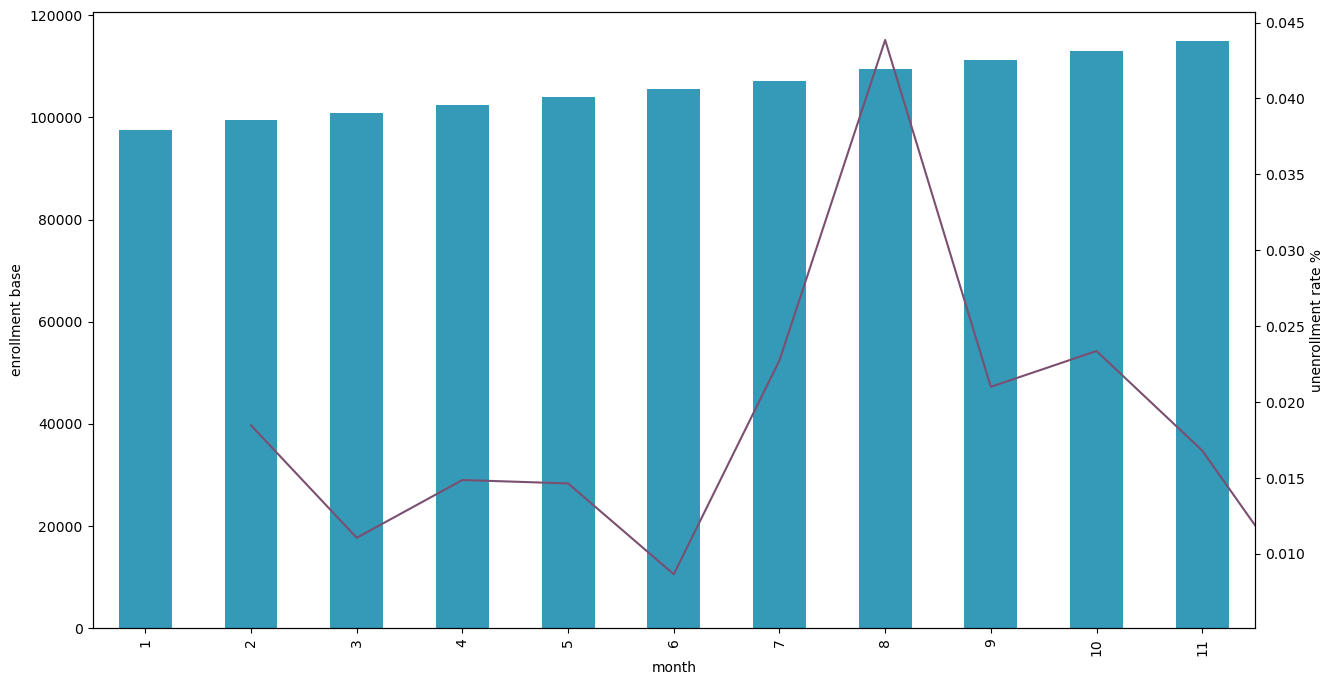

In [ ]:
complot(ace_push)
plt.show()

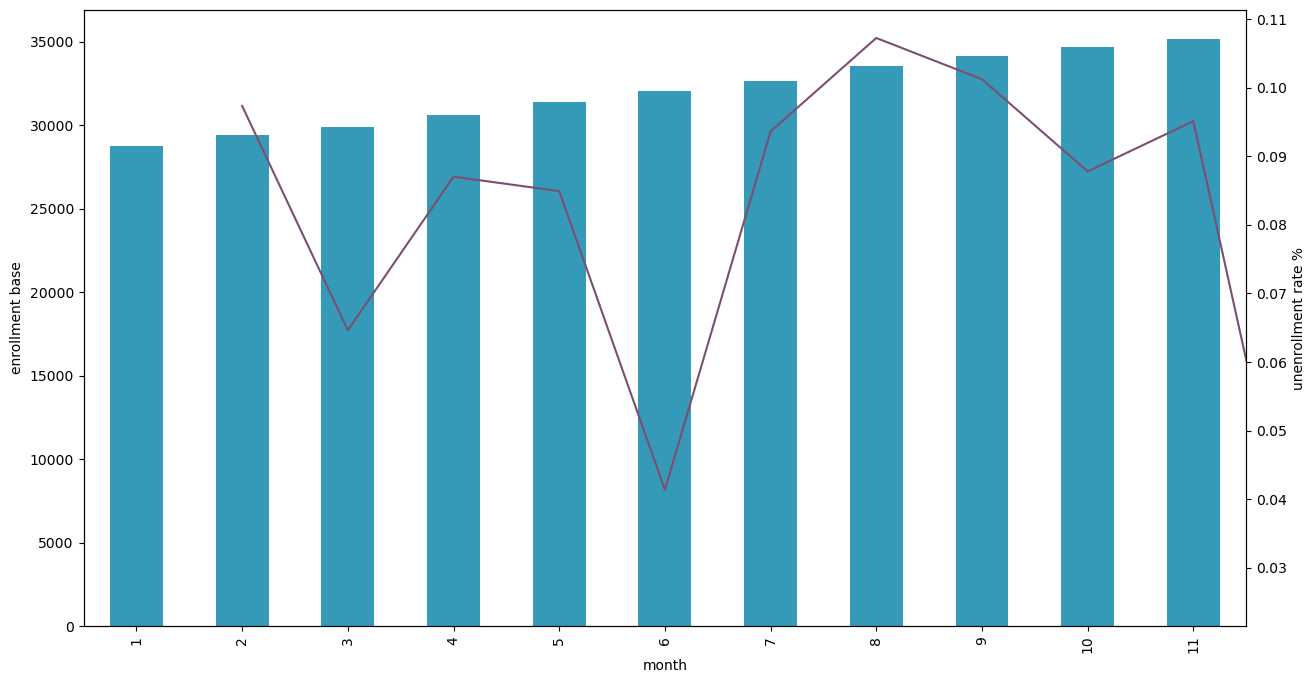

In [ ]:
complot(ace_email)
plt.show()

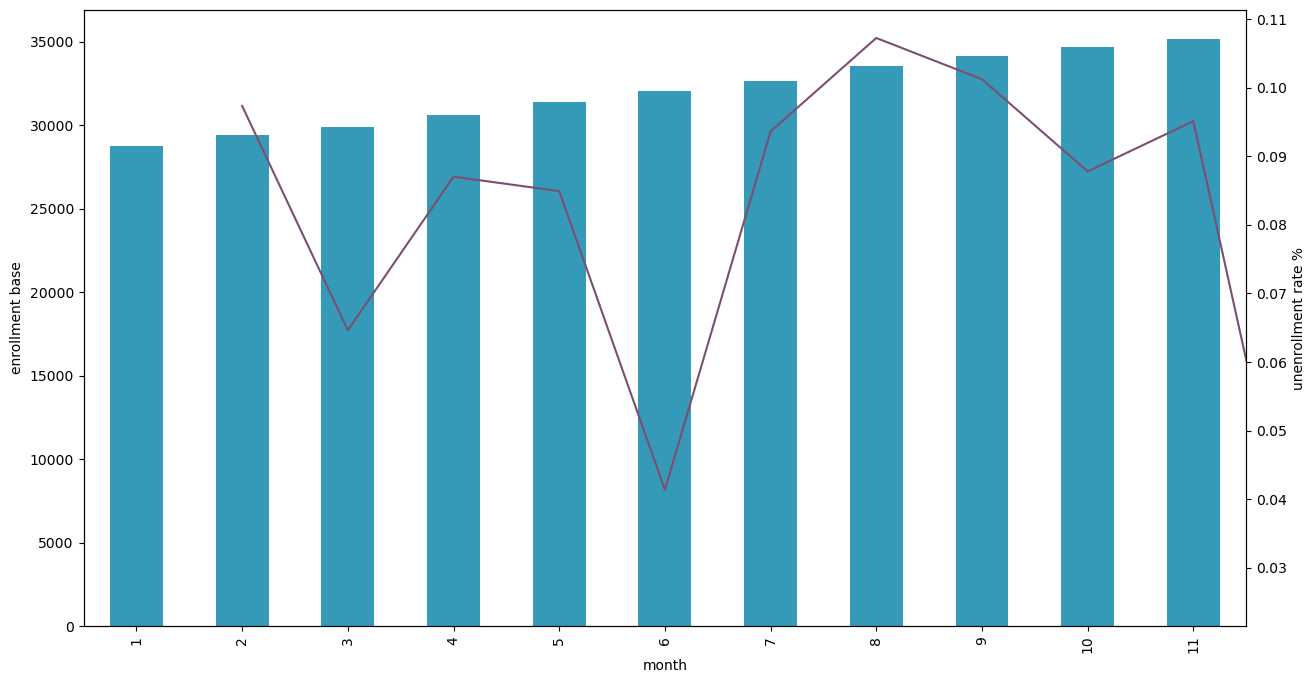

In [ ]:
complot(ace_email)
plt.show()